<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

**Описание проекта**

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Необходимо поcтроить модель для такого предсказания.

Значение метрики RMSE на тестовой выборке должно быть не больше 48.

**Ход работы**
1.	Загрузка данных и выполнение их ресемплирования по одному часу.
2.	Анализ данных.
3.	Обучение разных моделей с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4.	Проверка данных на тестовой выборке, вывод.

**Описание данных**

Данные лежат в файле `/datasets/taxi.csv.`

Количество заказов находится в столбце `num_orders` (от англ. number of orders, «число заказов»).


## Подготовка

### Загрузка, подготовка данных

In [1]:
# Импорты

import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import numpy as np
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
import lightgbm
from sklearn.model_selection import TimeSeriesSplit

Мы знаем, что будем работать с файлом, в котором имеется столбец с датами. Переведём его сразу в индекс в нужном формате.

In [2]:
df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

Проверяем:

In [3]:
df

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Убедимся, что данные расположены в хронологическом порядке:

In [5]:
df.index.is_monotonic

True

### Ресемплирование 

Имеющиеся данные имеют длину интервала 10 минут. Для решения нашей задачи необходимо ресемплировать данные с новой длиной интервала 1 час. Так как нам необходимо предсказать общую потребность водителей в час, вычислим сумму в новом интервале.

In [6]:
df = df.resample('1H').sum()
df

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


## Анализ

Рассмотрим полученный временной ряд.

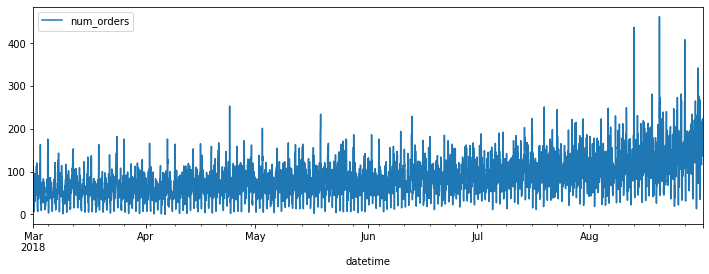

In [7]:
df.plot(figsize=(12,4));

Имеется сильные колебания графика. Предполагаем, что график меняет направление в течение дня (пики перед и после рабочего времени), в также в течение недели (пики в пятницу и субботу). Рассмотрим скользящие средние:

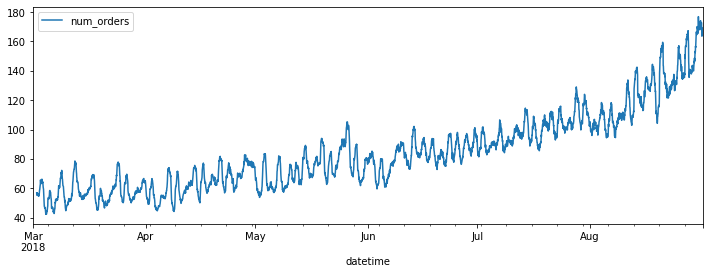

In [8]:
df.rolling(24).mean().plot(figsize=(12,4));

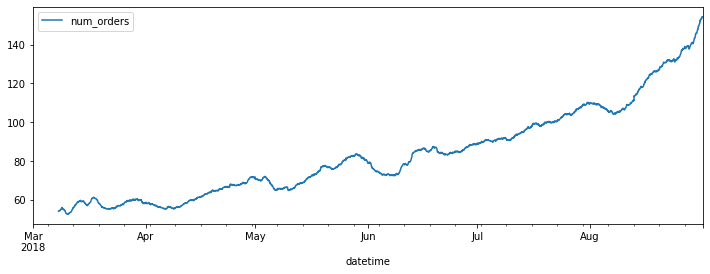

In [9]:
df.rolling(24*7).mean().plot(figsize=(12,4));

Проведём декомпозицию и рассмотрим подробнее тренд и сезонность данных.

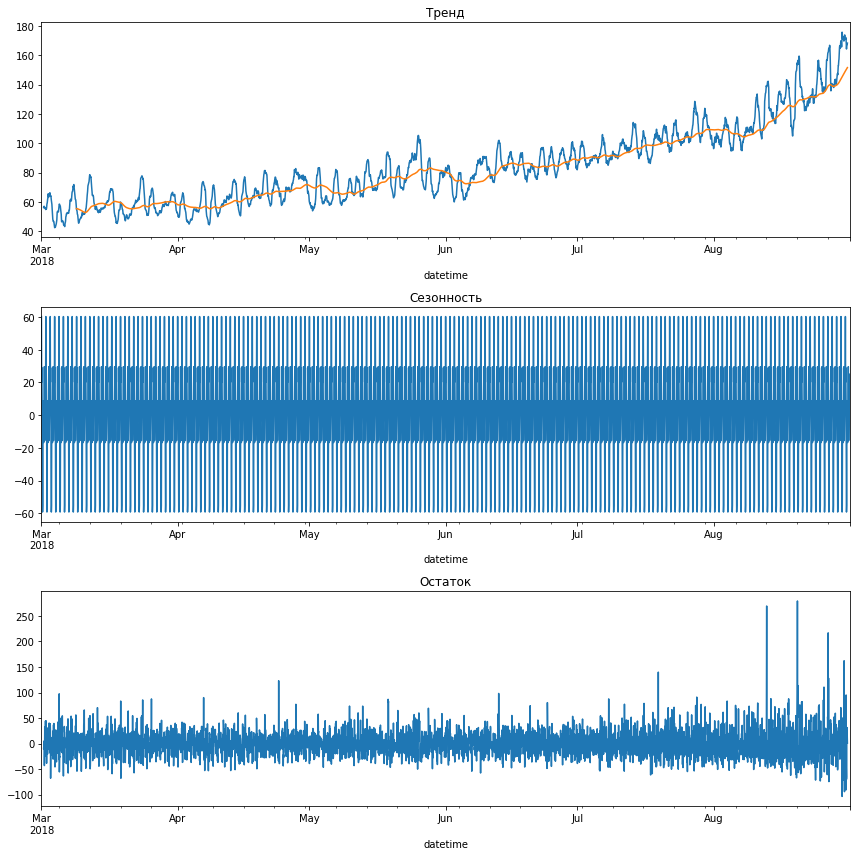

In [10]:
decomposed = seasonal_decompose(df)
plt.figure(figsize=(12, 12));
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
decomposed.trend.rolling(180).mean().plot(ax=plt.gca())
plt.title('Тренд')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Сезонность')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Остаток')
plt.tight_layout()

График имеет слишком большую рябь, рассмотрим двухнедельный срез.

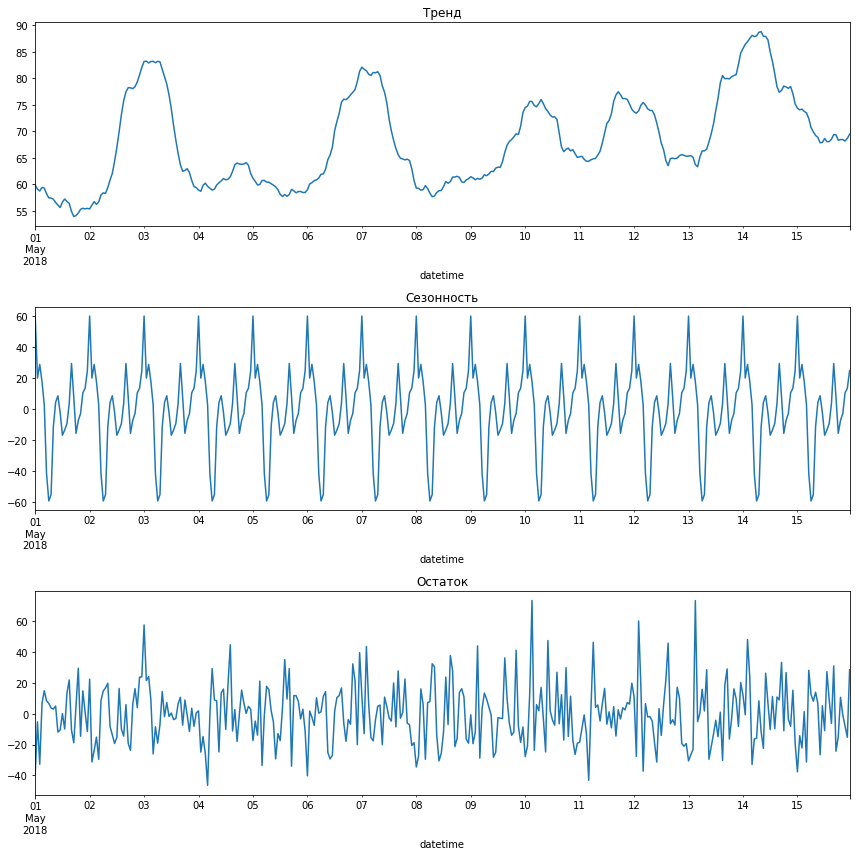

In [11]:
plt.figure(figsize=(12, 12));
plt.subplot(311)
decomposed.trend['2018-05-01':'2018-05-15'].plot(ax=plt.gca())
plt.title('Тренд')
plt.subplot(312)
decomposed.seasonal['2018-05-01':'2018-05-15'].plot(ax=plt.gca())
plt.title('Сезонность')
plt.subplot(313)
decomposed.resid['2018-05-01':'2018-05-15'].plot(ax=plt.gca())
plt.title('Остаток')
plt.tight_layout()

На графике остатка за весь период наблюдается повышенный разброс значений в августе. Рассмотрим стандартное отклонение:

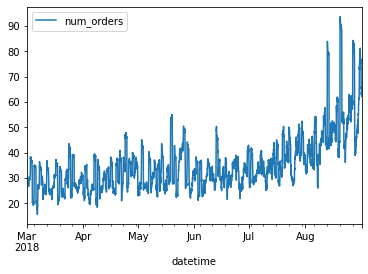

In [12]:
df.rolling(24).std().plot();

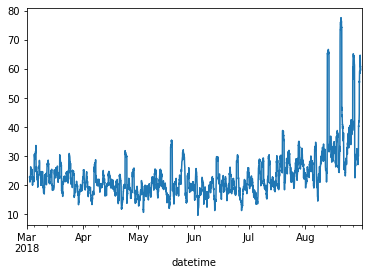

In [13]:
# Сравним с аналогичным графиком, построенному по остатку
decomposed.resid.rolling(24).std().plot(ax=plt.gca());

Из графика следует, что временной ряд не является стационарным.

### Вывод

- График имеет восходящий тренд на отрезке времени с марта по август;
- Сезонность имеется с циклом 1 сутки;
- В августе имеются пики количества заказов выше 400 в час;
- Временной ряд - не стационарный.

## Обучение

In [14]:
# Функции

# RMSE
def rmse(targets, predictions):
    rmse = mean_squared_error(targets, predictions) ** 0.5
    return rmse

rmse_score = make_scorer(rmse, greater_is_better=False)

# Создание признаков
def make_features(data, max_lag, rolling_mean_size):
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data.num_orders.shift(lag)
    data['rolling_mean'] = data.num_orders.shift().rolling(rolling_mean_size).mean()

In [15]:
make_features(df, 4, 4)

Разобьём выборку на обучающую и тестовую, где тестовая - 10% от исходных данных.

In [16]:
train, test = train_test_split(df, shuffle=False, test_size=0.1)

Убедимся, что данные разделили корректно:

In [17]:
print(train.shape, test.shape, test.shape[0]/df.shape[0])
print(train.index.min(), train.index.max())
print(test.index.min(), test.index.max())

(3974, 10) (442, 10) 0.10009057971014493
2018-03-01 00:00:00 2018-08-13 13:00:00
2018-08-13 14:00:00 2018-08-31 23:00:00


In [18]:
train = train.dropna()

In [19]:
features_train = train.drop('num_orders', axis=1)
features_test = test.drop('num_orders', axis=1)
target_train = train['num_orders']
target_test = test['num_orders']

Масштабируем данные. Полученные результаты зафиксируем в отдельных переменных.

In [20]:
scaler = StandardScaler()
scaler.fit(features_train)

features_train_scaled = scaler.transform(features_train)
features_test_scaled = scaler.transform(features_test)

In [21]:
# Проверяем
features_train_scaled

array([[-1.41347223, -1.59314186, -0.01283206, ...,  0.17463054,
         1.18404053,  0.27795726],
       [-1.41347223, -1.59314186, -0.01283206, ..., -0.18750533,
         0.1748973 , -0.40476527],
       [-1.41347223, -1.59314186, -0.01283206, ..., -0.31683957,
        -0.18735924, -1.07063045],
       ...,
       [ 1.75542587, -0.24053853, -1.51116391, ...,  0.32983163,
        -1.01537419,  0.9269651 ],
       [ 1.75542587, -0.24053853, -1.51116391, ...,  1.51970663,
         0.33015011,  1.81197579],
       [ 1.75542587, -0.24053853, -1.51116391, ...,  2.01117674,
         1.5204216 ,  1.82040446]])

In [22]:
# Переведём массивы в вид таблицы

features_train_scaled = pd.DataFrame(features_train_scaled, columns=features_train.columns)
features_test_scaled = pd.DataFrame(features_test_scaled, columns=features_test.columns)

In [23]:
# Проверяем
features_train_scaled

,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,rolling_mean
0,-1.413472,-1.593142,-0.012832,-1.083255,-0.317243,-0.187822,0.174631,1.184041,0.277957
1,-1.413472,-1.593142,-0.012832,-0.938675,-0.911959,-0.317110,-0.187505,0.174897,-0.404765
2,-1.413472,-1.593142,-0.012832,-0.794096,-1.868677,-0.911833,-0.316840,-0.187359,-1.070630
3,-1.413472,-1.593142,-0.012832,-0.649516,-1.713534,-1.868562,-0.911777,-0.316737,-1.567922
4,-1.413472,-1.593142,-0.012832,-0.504936,-1.635962,-1.713416,-1.868850,-0.911872,-1.997785
...,...,...,...,...,...,...,...,...,...
3965,1.755426,-0.240539,-1.511164,-0.360357,0.329188,-1.015263,-0.316840,0.123146,-0.286764
3966,1.755426,-0.240539,-1.511164,-0.215777,1.518621,0.329329,-1.015244,-0.316737,0.168385
3967,1.755426,-0.240539,-1.511164,-0.071197,2.009908,1.518775,0.329832,-1.015374,0.926965
3968,1.755426,-0.240539,-1.511164,0.073382,1.699621,2.010068,1.519707,0.330150,1.811976


Данные выглядят корректными - одинаковые значения у одинаковых дней недели и скольжение у столбцов 'lag'.

### Линейная регрессия

In [24]:
model_lr = LinearRegression()

In [25]:
%%time

model_lr.fit(features_train, target_train)

CPU times: user 0 ns, sys: 3.75 ms, total: 3.75 ms
Wall time: 3.12 ms


LinearRegression()

In [26]:
%%time

prediction_lr_train = model_lr.predict(features_train)

CPU times: user 36.5 ms, sys: 84.8 ms, total: 121 ms
Wall time: 62.2 ms


In [27]:
print('RMSE модели линейной регрессии:', rmse(prediction_lr_train, target_train))

RMSE модели линейной регрессии: 30.500374252442192


Полученного результата достаточно для решения задачи. Целевой порог RMSE 48 пройден. Модель допустим до тестирования.

### Дерево решений

In [28]:
model_dtr = DecisionTreeRegressor(random_state=777)

In [29]:
%%time

model_dtr.fit(features_train, target_train)

CPU times: user 23.8 ms, sys: 0 ns, total: 23.8 ms
Wall time: 23.2 ms


DecisionTreeRegressor(random_state=777)

In [30]:
%%time

prediction_dtr_train = model_dtr.predict(features_train)

CPU times: user 3.46 ms, sys: 0 ns, total: 3.46 ms
Wall time: 3.48 ms


In [31]:
print('RMSE модели дерева решений:', rmse(prediction_dtr_train, target_train))

RMSE модели дерева решений: 0.0


Скорее всего, модель переобучена и запомнила результат каждого часа в выборке. Проверим в дальнейшем модель на тестовой выборке.

### Случайный лес

Подберём гиперпараметры для модели случайного леса

In [32]:
rfr_null = RandomForestRegressor()
rfr_params = {'max_depth': range (12, 15, 2), # Сокращено для экономии времени исполнения кода
              'n_estimators': range (80, 100, 5), # Сокращено для экономии времени исполнения кода
              'random_state': [777]}

In [33]:
tscv = TimeSeriesSplit(n_splits=9)
rfr_grid = GridSearchCV(rfr_null, rfr_params, scoring='neg_root_mean_squared_error', cv=tscv)
rfr_grid.fit(features_train, target_train)
predict_grid = rfr_grid.predict(features_train)
print('Гиперпараметры:', rfr_grid.best_params_)
print('nRMSE:', abs(rfr_grid.best_score_))

Гиперпараметры: {'max_depth': 14, 'n_estimators': 90, 'random_state': 777}
nRMSE: 24.435971136952595


Гиперпараметры: {'max_depth': 14, 'n_estimators': 90, 'random_state': 777}

nRMSE: 24.44

Полученного результата достаточно для решения задачи. Модель допустим до тестирования на тестовой выборке, предварительно создав её с полученными гиперпараметрами.

In [34]:
model_rfr = RandomForestRegressor(max_depth=14, n_estimators=90, random_state=777)
model_rfr.fit(features_train, target_train)

RandomForestRegressor(max_depth=14, n_estimators=90, random_state=777)

### CatBoostRegressor

Построим модель с использованием алгоритмов CatBoostRegressor😻.

Подберём параметры:

In [36]:
grid_cbr_params = {'depth': range(6, 10), # рекомендуется по документации
                  'learning_rate': [0.1],# настраивал на диапазоне, сократил для ускорения работы кода
                  'l2_leaf_reg': range(1, 10, 4), # настраивал на большем диапазоне, сократил для ускорения работы кода
                  'iterations': [200]}

model_cbr = CatBoostRegressor(random_state=777, loss_function='RMSE')

grid_searching = model_cbr.grid_search(grid_cbr_params, X=features_train, y=target_train)

grid_searching['params']

0:	learn: 80.0572023	test: 79.5787212	best: 79.5787212 (0)	total: 48.8ms	remaining: 9.71s
1:	learn: 73.5972246	test: 73.0475052	best: 73.0475052 (1)	total: 50.7ms	remaining: 5.02s
2:	learn: 67.6109068	test: 67.0352586	best: 67.0352586 (2)	total: 52.5ms	remaining: 3.45s
3:	learn: 62.3327136	test: 61.7413802	best: 61.7413802 (3)	total: 54.5ms	remaining: 2.67s
4:	learn: 57.7702720	test: 57.1918345	best: 57.1918345 (4)	total: 56.2ms	remaining: 2.19s
5:	learn: 53.8110939	test: 53.2404077	best: 53.2404077 (5)	total: 57.9ms	remaining: 1.87s
6:	learn: 50.2039957	test: 49.5976221	best: 49.5976221 (6)	total: 59.5ms	remaining: 1.64s
7:	learn: 46.7871733	test: 46.1629917	best: 46.1629917 (7)	total: 61.3ms	remaining: 1.47s
8:	learn: 43.8518115	test: 43.1974305	best: 43.1974305 (8)	total: 63.2ms	remaining: 1.34s
9:	learn: 41.2375038	test: 40.5780839	best: 40.5780839 (9)	total: 64.8ms	remaining: 1.23s
10:	learn: 39.0147615	test: 38.3146136	best: 38.3146136 (10)	total: 66.5ms	remaining: 1.14s
11:	lear

{'depth': 7, 'l2_leaf_reg': 1, 'iterations': 200, 'learning_rate': 0.1}

bestTest = 22.51163083

bestIteration = 187

Лучшие гиперпараметры: 'depth': 7, 'l2_leaf_reg': 1, 'iterations': 200, 'learning_rate': 0.1

Результат допустимый. Запишем полученные гиперпараметры в модель для последующего тестирования.

In [37]:
model_cbr = CatBoostRegressor(random_state=777, loss_function='RMSE', depth=7, l2_leaf_reg=1, iterations=200, learning_rate=0.1)

In [38]:
%%time

model_cbr.fit(features_train, target_train, verbose=50)

0:	learn: 36.7779384	total: 4.58ms	remaining: 911ms
50:	learn: 21.0700438	total: 182ms	remaining: 531ms
100:	learn: 18.3072600	total: 334ms	remaining: 328ms
150:	learn: 16.2956493	total: 530ms	remaining: 172ms
199:	learn: 14.9011108	total: 697ms	remaining: 0us
CPU times: user 735 ms, sys: 4.8 ms, total: 740 ms
Wall time: 1.33 s


### LightGBM

In [43]:
%%time

grid_lgbm_params = {'max_depth': range(5, 7, 2)}

model_lgbm = lightgbm.LGBMRegressor()

grid_searching_lgbm = GridSearchCV(model_lgbm, grid_lgbm_params, scoring=rmse_score, cv=tscv)
grid_searching_lgbm.fit(features_train, target_train)

print(grid_searching_lgbm.best_params_)
print(grid_searching_lgbm.best_score_)

{'max_depth': 5}
-24.370853839422725
CPU times: user 23 s, sys: 235 ms, total: 23.2 s
Wall time: 23.4 s


In [44]:
predictions_lgbm = grid_searching_lgbm.predict(features_train)

In [45]:
rmse(predictions_lgbm, target_train)

17.13653695909325

Зафиксируем параметры и протестируем на тестовой выборке.

In [46]:
model_lgbm = lightgbm.LGBMRegressor(max_depth=7)
model_lgbm.fit(features_train, target_train)

LGBMRegressor(max_depth=7)

## Тестирование

Проверим качество моделей, не основанных на машинном обучении: константой и предыдущим значением ряда:

In [47]:
pred_median = np.ones(test.shape) * train.num_orders.median()
print('RMSE константной модели:', rmse(pred_median, test))

RMSE константной модели: 77.4858612668593


In [48]:
pred_previous = test.shift(fill_value=train.num_orders[-1])
print('RMSE по предыдущему значению:', rmse(pred_previous, test))

RMSE по предыдущему значению: 42.34049086028163


Качества константной модели недостаточно для решения задачи.

Качество модели "предыдущего значения" достаточное, но мы знаем, что в течение суток приращение может сильно меняться, поэтому такая модель не является надёжной.

Рассмотрим качество моделей машинного обучения:

### Линейная регрессия

In [85]:
%%time

prediction_lr_test = model_lr.predict(features_test)

CPU times: user 2.95 ms, sys: 0 ns, total: 2.95 ms
Wall time: 2.82 ms


In [86]:
print('RMSE модели линейной регрессии:', rmse(prediction_lr_test, target_test))

RMSE модели линейной регрессии: 52.574506853736935


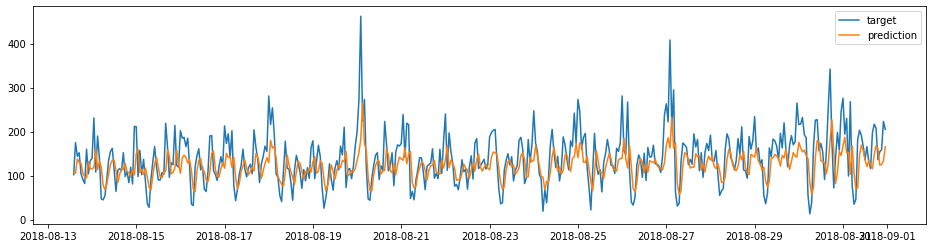

In [87]:
fig, ax = plt.subplots(figsize=(16, 4))
ax.plot(target_test, label="target") 
ax.plot(pd.DataFrame(prediction_lr_test, index=target_test.index), label="prediction")
ax.legend();

### Дерево решений

In [88]:
%%time

prediction_dtr_test = model_dtr.predict(features_test)

CPU times: user 3.28 ms, sys: 36 µs, total: 3.31 ms
Wall time: 2.54 ms


In [89]:
print('RMSE модели дерева решений:', rmse(prediction_dtr_test, target_test))

RMSE модели дерева решений: 52.82989435496309


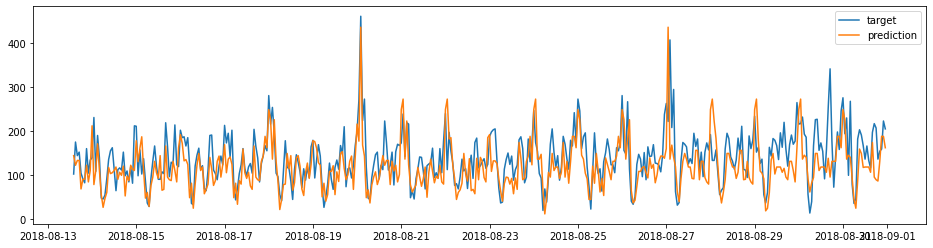

In [90]:
fig, ax = plt.subplots(figsize=(16, 4))
ax.plot(target_test, label="target") 
ax.plot(pd.DataFrame(prediction_dtr_test, index=target_test.index), label="prediction")
ax.legend();

### Случайный лес

In [91]:
%%time

prediction_rfr_test = model_rfr.predict(features_test)

CPU times: user 12.9 ms, sys: 7.42 ms, total: 20.3 ms
Wall time: 17.9 ms


In [92]:
print('RMSE модели дерева решений:', rmse(prediction_rfr_test, target_test))

RMSE модели дерева решений: 47.48832950286298


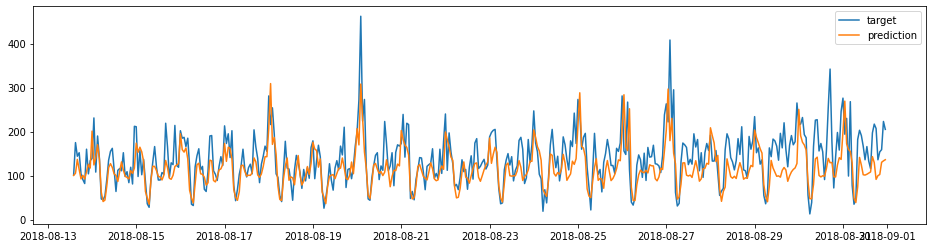

In [93]:
fig, ax = plt.subplots(figsize=(16, 4))
ax.plot(target_test, label="target") 
ax.plot(pd.DataFrame(prediction_rfr_test, index=target_test.index), label="prediction")
ax.legend();

### CatBoostRegressor

In [94]:
%%time

prediction_cbr_test = model_cbr.predict(features_test)

CPU times: user 2.44 ms, sys: 0 ns, total: 2.44 ms
Wall time: 1.68 ms


In [95]:
print('RMSE модели CatBoostRegressor:', rmse(prediction_cbr_test, target_test))

RMSE модели CatBoostRegressor: 43.665715289013164


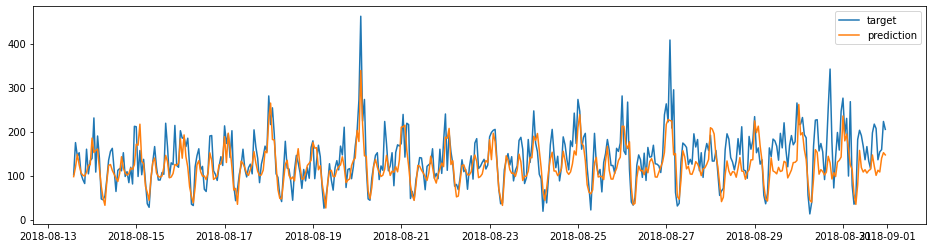

In [96]:
fig, ax = plt.subplots(figsize=(16, 4))
ax.plot(target_test, label="target") 
ax.plot(pd.DataFrame(prediction_cbr_test, index=target_test.index), label="prediction")
ax.legend();

### LightGBM

In [97]:
%%time

prediction_lgbm_test = model_lgbm.predict(features_test)

CPU times: user 43 ms, sys: 0 ns, total: 43 ms
Wall time: 10 ms


In [98]:
print('RMSE модели LightGBM:', rmse(prediction_lgbm_test, target_test))

RMSE модели LightGBM: 44.91961223082438


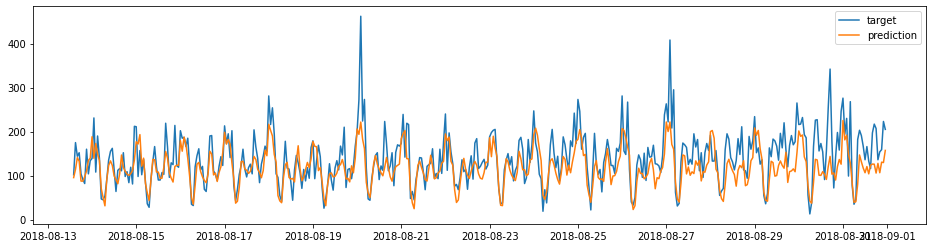

In [99]:
fig, ax = plt.subplots(figsize=(16, 4))
ax.plot(target_test, label="target") 
ax.plot(pd.DataFrame(prediction_lgbm_test, index=target_test.index), label="prediction")
ax.legend();


## Вывод

В результате работы проанализировали информацию по количеству поездок за март-август 2018 года. Данные ресемплировали по 1 часу. 

На основании полученных данных построили модели машинного обучения. В результате тестирования получили следующие результаты работы моделей:

<table width=300>
 <caption>Качество работы моделей</caption>
 <tr>
  <th>Модель</th>
  <th>RMSE</th>
 </tr>
 <tr><td>Линейная регрессия</td><td>52.6</td></tr>
 <tr><td>Дерево решений</td><td>52.8</td></tr>
 <tr><td>Случайный лес</td><td>47.5</td></tr>
 <tr><td>CatBoostRegressor</td><td>43.7</td></tr>
 <tr><td>LightGBM</td><td>44.9</td></tr>
</table>

В допуске работают модели случайного леса, CatBoostRegressor и LightGBM.

Для прогнозирования нагрузки на службу такси в следующем часе рекомендуется использовать модель CatBoostRegressor.

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [x]  Качество моделей проверено, выводы сделаны
- [x]  Значение *RMSE* на тестовой выборке не больше 48